In [8]:
%load_ext autoreload
%autoreload 2
from itertools import islice, product
from typing import Any, Callable, Optional, Sequence, Type, Union

import einops as eo
import numpy as np
import scipy.io as sio
import torch
import torchkbnufft as tkbn

from mrboost import computation as comp
from mrboost import preprocessing as pre
from mrboost.coil_sensitivity_estimation import (
    CoilSensitivityEstimator,
    Lowk_2D_CSE,
    Lowk_3D_CSE,
)
from mrboost.density_compensation import (
    cihat_pipe_density_compensation,
    voronoi_density_compensation,
)
from mrboost.io_utils import *
from mrboost.mapvbvd import mapVBVD
from mrboost.twix_metadata_def import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
class Reconstructor:
    def __init__(
        self,
        dat_file_location: Path = Path(
            "/data/anlab/PET_MOCO/PETMRdata/CAPTURE_DCE/ONC-DCE-004/meas_MID00165_FID04589_Abd_CAPTURE_FA15_Dyn.dat"
        ),
        which_slice: Union[int, Sequence] = (0, 80),
        device: torch.device = torch.device("cpu"),
        *args,
        **kwargs,
    ) -> None:
        self.dat_file_location = dat_file_location
        self.which_slice = which_slice
        self.device = device
        # data_raw = self.__get_raw_data(dat_file_location)
        # self.__args_init(*args,**kwargs)
        # data_dict = self.__data_preprocess(data_raw)
        # self.img = self.reconstruction(data_dict)

    def get_raw_data(self, dat_file_location):
        twixobj, self.mdh = mapVBVD(dat_file_location)
        # try:
        self.twixobj = twixobj[-1]
        # except KeyError:
        #     self.twixobj = twixobj
        self.twixobj.image.squeeze = True
        self.twixobj.image.flagRemoveOS = False
        data_raw = eo.rearrange(
            self.twixobj.image[""],
            "spoke_len ch_num spoke_num partition_num -> ch_num partition_num spoke_num spoke_len",
        )
        self.shape_dict = eo.parse_shape(
            data_raw, "ch_num partition_num spoke_num spoke_len"
        )
        # print(self.shape_dict)
        return data_raw

    def __args_init(self, *args, **kwargs):
        self.amplitude_scale_factor = 80 * 20 * 131072 / 65536 * 20000

        self.kspace_centre_partition_num = int(
            self.mdh.ushKSpaceCentrePartitionNo[0]
        )  # important! -1 because of nav

        self.ch_num = self.shape_dict["ch_num"]
        self.total_partition_num = self.shape_dict["partition_num"]
        self.partition_num = (
            self.total_partition_num - 1
        )  # this number does not contain navigator
        self.spoke_num = self.shape_dict["spoke_num"]
        self.spoke_len = self.shape_dict["spoke_len"]

        self.TR = self.twixobj.hdr.MeasYaps[("alTR", "0")] / 1000
        self.T = (
            self.TR * self.total_partition_num * 1e-3 + 18.86e-3
        )  # 19e-3 is for Q-fat sat
        self.Fs = 1 / self.T
        try:
            self.FOV = self.twixobj.hdr.Meas.RoFOV  # type: ignore
        except AttributeError:
            self.FOV = self.twixobj.hdr.Protocol.RoFOV

        self.im_size = (self.spoke_len // 2, self.spoke_len // 2)
        self.grid_size = (int(2 * self.spoke_len), int(2 * self.spoke_len))

    def args_init_post(self, *args, **kwargs):
        pass

    def args_init_before(self, *args, **kwargs):
        pass

    def args_init(self, *args, **kwargs):
        self.args_init_before(*args, **kwargs)
        self.__args_init(*args, **kwargs)
        self.args_init_post(*args, **kwargs)

    def data_preprocess(self, data_raw):
        # need to overload in child reconsturctor
        kspace_traj = None
        return dict(kspace_data=data_raw, kspace_traj=kspace_traj)

    def reconstruction(self, data_dict):
        kspace_data, kspace_traj = data_dict["kspace_data"], data_dict["kspace_traj"]

In [ ]:
class BlackBoneStackOfStars_Subset_4DL_LowResZ(Reconstructor):
    def __init__(
        self,
        dat_file_location: Path = Path(
            "/data/anlab/Chunxu/meas_MID00017_FID93856_fl3d_vibe_GA_BlackBone_20210507.dat"
        ),
        spokes_to_recon: Union[int, Sequence] = (6, 400),  # (0,-1)  -1 means all
        which_slice: Union[int, Sequence] = (0, 80),
        percentW: float = 12.5,
        cache_folder: Path = Path(".") / "cache",
        device: torch.device = torch.device("cpu"),
    ) -> None:
        self.percentW = percentW
        self.cache_folder = cache_folder
        self.spokes_to_recon = spokes_to_recon

        super().__init__(dat_file_location, which_slice, device)

    def args_init_post(self):
        self.slice_num = round(self.twixobj.hdr.Meas.lImagesPerSlab)
        if self.which_slice == -1:
            self.which_slice = (0, self.slice_num)
        self.which_slice = (
            (self.which_slice, self.which_slice + 1)
            if isinstance(self.which_slice, int)
            else self.which_slice
        )
        assert (
            self.which_slice[1] <= self.slice_num
        ), f"Try to set {self.which_slice[1]=} <= {self.slice_num=}"
        self.slice_to_recon = [i for i in range(self.slice_num)][
            slice(*self.which_slice)
        ]

        # build nufft operators
        # self.adjnufft_ob = tkbn.KbNufftAdjoint(
        #     im_size=self.im_size, grid_size=self.grid_size
        # ).to(self.device)
        # self.nufft_ob = tkbn.KbNufft(im_size=self.im_size, grid_size=self.grid_size).to(
        #     self.device
        # )
        self.adjnufft, self.nufft = comp.generate_nufft_op(self.im_size)

    def data_preprocess(self, data_raw):
        data_raw *= self.amplitude_scale_factor
        kspace_data_raw = data_raw[
            :, :, self.spokes_to_recon[0] : self.spokes_to_recon[1], :
        ]

        kspace_traj = (
            2
            * torch.pi
            * comp.generate_golden_angle_radial_spokes_kspace_trajctory(
                self.spoke_num, self.spoke_len
            )[self.spokes_to_recon[0] : self.spokes_to_recon[1]]
        )

        kspace_data_centralized, kspace_data_z = self.kspace_data_preprocess(
            kspace_data_raw
        )

        # cse = Lowk_2D_CSE(kspace_data_centralized, kspace_traj, self.nufft_ob, self.adjnufft_ob,
        #                   hamming_filter_ratio=0.05, batch_size=1, device=self.device)

        cse = Lowk_3D_CSE(
            kspace_data_centralized,
            kspace_traj,
            self.nufft,
            self.adjnufft,
            self.im_size
            hamming_filter_ratio=[0.05, 0.05],
            batch_size=2,
            device=self.device,
        )
        sp = eo.parse_shape(kspace_data_z, "ch slice_num spoke_num spoke_len")
        kspace_density_compensation = torch.zeros(
            (sp["spoke_num"], sp["spoke_len"]),
            dtype=torch.float32,
            device=kspace_traj.device,
        )
        # (self.contra_to_recon,self.phase_to_recon,self.spokes_per_phase,self.spoke_len))
        kspace_density_compensation = voronoi_density_compensation(
            kspace_traj,
            im_size=self.im_size,
            grid_size=self.grid_size,
            device=kspace_traj.device,
        )
        return dict(
            kspace_data=kspace_data_z,
            kspace_traj=kspace_traj,
            kspace_density_compensation=kspace_density_compensation,
            cse=cse,
        )

    def kspace_data_preprocess(self, kspace_data_raw):
        kspace_data_centralized = comp.centralize_kspace(
            kspace_data=torch.from_numpy(kspace_data_raw),
            acquire_length=self.partition_num,
            # -1 because of navigator, and this number is index started from 0
            center_idx_in_acquire_lenth=self.kspace_centre_partition_num - 1,
            full_length=self.slice_num,
            dim=1,
        )

        kspace_data_z = comp.batch_process(batch_size=2, device=self.device)(
            comp.ifft_1D
        )(kspace_data_centralized, dim=1)
        # flip or not, doesnt change much
        kspace_data_z = torch.flip(kspace_data_z, dims=(1,))
        return kspace_data_centralized, kspace_data_z

    def reconstruction(self, data_dict):
        kspace_data, kspace_traj, kspace_density_compensation, cse = (
            data_dict["kspace_data"],
            data_dict["kspace_traj"],
            data_dict["kspace_density_compensation"],
            data_dict["cse"],
        )

        img = torch.zeros(
            (len(self.slice_to_recon), self.im_size[0] // 2, self.im_size[1] // 2),
            dtype=torch.complex64,
        )
        sensitivity_map = cse[0, 0].to(torch.complex64).conj()[:, self.slice_to_recon]
        output = comp.batch_process(batch_size=2, device=self.device)(
            comp.recon_adjnufft
        )(
            kspace_data,  # , self.first_slice:args.last_slice],
            kspace_traj=kspace_traj,
            kspace_density_compensation=kspace_density_compensation,
            adjnufft_ob=self.adjnufft,
        )[
            :,
            self.slice_to_recon,
        ]
        output *= sensitivity_map
        img = eo.reduce(torch.flip(output, (-1,)), "ch slice w h -> slice w h", "sum")
        return img

    def forward(self):
        data_raw = self.get_raw_data(self.dat_file_location)
        self.args_init()
        data_dict = self.data_preprocess(data_raw)
        img = self.reconstruction(data_dict)
        return img

In [ ]:
class CAPTURE_VarW_NQM_DCE_PriorInj(Reconstructor):
    def __init__(
        self,
        dat_file_location: Path = Path(
            "/data/anlab/PET_MOCO/PETMRdata/CAPTURE_DCE/ONC-DCE-004/meas_MID00165_FID04589_Abd_CAPTURE_FA15_Dyn.dat"
        ),
        phase_num: int = 10,
        percentW: float = 12.5,
        which_slice: int = -1,
        cache_folder: Path = Path(".") / "cache",
        device: torch.device = torch.device("cuda"),
    ) -> None:
        self.phase_num = phase_num
        self.spokes_per_phase = 15
        self.percentW = percentW
        self.cache_folder = cache_folder

        super().__init__(dat_file_location, which_slice, device)

    def args_init_post(self):
        self.slice_num = round(
            self.twixobj.hdr.Meas.lImagesPerSlab
            * (1 + self.twixobj.hdr.Meas.dSliceOversamplingForDialog)
        )
        if self.which_slice == -1:
            self.which_slice = (0, self.slice_num)
        self.which_slice = (
            (self.which_slice, self.which_slice + 1)
            if isinstance(self.which_slice, int)
            else self.which_slice
        )
        assert (
            self.which_slice[1] <= self.slice_num
        ), f"Try to set {self.which_slice[1]=} <= {self.slice_num=}"
        self.slice_to_recon = [i for i in range(self.slice_num)][
            slice(*self.which_slice)
        ]

        self.start_spokes_to_discard = max(
            max(self.phase_num, 10), self.phase_num * np.ceil(10 / self.phase_num)
        )

        self.binning_start_idx = self.start_spokes_to_discard
        self.binning_end_idx = (
            self.start_spokes_to_discard + self.phase_num * self.spokes_per_phase
        )

        # build nufft operators
        self.adjnufft = tkbn.KbNufftAdjoint(
            im_size=self.im_size, grid_size=self.grid_size
        ).to(self.device)
        self.nufft = tkbn.KbNufft(im_size=self.im_size, grid_size=self.grid_size).to(
            self.device
        )

    def data_preprocess(self, data_raw):
        data_raw *= self.amplitude_scale_factor
        kspace_data_raw = data_raw[:, 1:, self.start_spokes_to_discard :, :]
        nav = eo.rearrange(
            data_raw[:, 0, self.start_spokes_to_discard :, :],
            "ch_num spoke_num spoke_len -> spoke_len spoke_num ch_num",
        )
        kspace_traj = (
            2
            * torch.pi
            * comp.generate_golden_angle_radial_spokes_kspace_trajctory(
                self.spoke_num, self.spoke_len
            )[self.start_spokes_to_discard :]
        )

        sorted_r_idx = self.navigator_preprocess(nav)
        (
            kspace_data_centralized,
            kspace_data_mask,
            kspace_data_z,
        ) = self.kspace_data_preprocess(kspace_data_raw)

        cse = Lowk_2D_CSE(
            kspace_data_centralized,
            kspace_traj,
            self.nufft,
            self.adjnufft,
            self.im_size,
            hamming_filter_ratio=0.05,
            batch_size=1,
            device=self.device,
        )

        kspace_traj, kspace_data_z, kspace_data_centralized, kspace_data_mask = map(
            comp.data_binning_phase,
            [
                kspace_traj[self.binning_start_idx : self.binning_end_idx],
                kspace_data_z[:, :, self.binning_start_idx : self.binning_end_idx],
                kspace_data_centralized[
                    :, :, self.binning_start_idx : self.binning_end_idx
                ],
                kspace_data_mask[:, :, self.binning_start_idx : self.binning_end_idx],
            ],
            [sorted_r_idx] * 4,
            [self.phase_num] * 4,
            [self.spokes_per_phase] * 4,
        )
        sp = eo.parse_shape(kspace_data_z, "phase_num ch slice_num spoke_num spoke_len")
        kspace_density_compensation = torch.zeros(
            (sp["phase_num"], sp["spoke_num"], sp["spoke_len"]),
            dtype=torch.float32,
            device=kspace_traj.device,
        )
        for ph in range(self.phase_num):
            kspace_density_compensation[ph] = voronoi_density_compensation(
                kspace_traj[ph],
                device=kspace_traj.device,
            )
        return dict(
            kspace_data_centralized=kspace_data_centralized,
            kspace_data_mask=kspace_data_mask,
            kspace_data_z=kspace_data_z,
            kspace_traj=kspace_traj,
            kspace_density_compensation=kspace_density_compensation,
            cse=cse,
        )

    def navigator_preprocess(self, nav):
        ch, rotation, respiratory_curve = comp.tuned_and_robust_estimation(
            navigator=nav,
            percentW=self.percentW,
            Fs=self.Fs,
            FOV=self.FOV,
            ndata=self.spoke_len,
            device=self.device,
        )
        sorted_r, sorted_r_idx = torch.sort(
            respiratory_curve[self.binning_start_idx : self.binning_end_idx], dim=-1
        )
        # in each of the contrast, we sort the respiratory curve in order to classify respiratory phases
        return sorted_r_idx

    def kspace_data_preprocess(self, kspace_data_raw):
        kspace_data_centralized, kspace_data_mask = comp.centralize_kspace(
            kspace_data=torch.from_numpy(kspace_data_raw),
            acquire_length=self.partition_num,
            # -1 because of navigator, and this number is index started from 0
            center_idx_in_acquire_lenth=self.kspace_centre_partition_num - 1,
            full_length=self.slice_num,
            dim=1,
        )
        kspace_data_z = comp.batch_process(batch_size=2, device=self.device)(
            comp.ifft_1D
        )(kspace_data_centralized, dim=1)
        return kspace_data_centralized, kspace_data_mask, kspace_data_z

    def reconstruction(self, data_dict, phase, return_multi_channel=False):
        kspace_data_z, kspace_traj, kspace_density_compensation, cse = (
            data_dict["kspace_data_z"],
            data_dict["kspace_traj"],
            data_dict["kspace_density_compensation"],
            data_dict["cse"],
        )
        sp = eo.parse_shape(kspace_data_z, "phase_num ch slice_num spoke_num spoke_len")
        ph = phase
        img_multi_ch = comp.batch_process(batch_size=2, device=self.device)(
            comp.recon_adjnufft
        )(
            kspace_data_z[ph, :],  # , self.first_slice:args.last_slice],
            kspace_traj=kspace_traj[ph],
            kspace_density_compensation=kspace_density_compensation[ph],
            adjnufft_ob=self.adjnufft,
        )[
            :,
            self.slice_to_recon,
        ]
        sensitivity_map = cse[0, ph].to(torch.complex64).conj()[:, self.slice_to_recon]
        img = eo.reduce(
            img_multi_ch * sensitivity_map, "ch slice w h -> slice w h", "sum"
        )
        if not return_multi_channel:
            return img
        else:
            return img, img_multi_ch

    def forward(self):
        data_raw = self.get_raw_data(self.dat_file_location)
        self.args_init()
        data_dict = self.data_preprocess(data_raw)
        img = self.reconstruction(data_dict)
        return img

In [ ]:
class CAPTURE_VarW_NQM_DCE_PostInj(Reconstructor):
    def __init__(
        self,
        dat_file_location: Path = Path(
            "/data/anlab/PET_MOCO/PETMRdata/CAPTURE_DCE/ONC-DCE-004/meas_MID00165_FID04589_Abd_CAPTURE_FA15_Dyn.dat"
        ),
        phase_num: int = 5,
        which_slice: Union[int, Sequence] = -1,
        which_contra: Union[int, Sequence] = -1,
        which_phase: Union[int, Sequence] = -1,
        injection_time: int = 30,
        duration_to_reconstruct: int = 340,
        time_per_contrast: int = 10,
        percentW: float = 12.5,
        cache_folder: Path = Path(".") / "cache",
        device: torch.device = torch.device("cuda"),
    ) -> None:
        self.phase_num = phase_num
        self.which_contra = which_contra
        self.which_phase = which_phase
        self.injection_time = injection_time
        self.duration_to_reconstruct = duration_to_reconstruct
        self.time_per_contrast = time_per_contrast
        self.percentW = percentW
        self.cache_folder = cache_folder

        super().__init__(dat_file_location, which_slice, device)

    def args_init_post(self):
        self.slice_num = round(
            self.twixobj.hdr.Meas.lImagesPerSlab
            * (1 + self.twixobj.hdr.Meas.dSliceOversamplingForDialog)
        )
        if self.which_slice == -1:
            self.which_slice = (0, self.slice_num)
        self.which_slice = (
            (self.which_slice, self.which_slice + 1)
            if isinstance(self.which_slice, int)
            else self.which_slice
        )
        assert (
            self.which_slice[1] <= self.slice_num
        ), f"Try to set {self.which_slice[1]=} <= {self.slice_num=}"
        self.slice_to_recon = [i for i in range(self.slice_num)][
            slice(*self.which_slice)
        ]

        self.start_spokes_to_discard = max(
            max(self.phase_num, 10), self.phase_num * np.ceil(10 / self.phase_num)
        )

        nSpokesToWorkWith = np.floor(self.duration_to_reconstruct / self.T)
        # per contrast from injection time. (Jan )
        # Exclude the first 10 prep spokes
        self.spokes_to_skip = round(
            (self.injection_time - self.time_per_contrast) / self.T
        )  # self.start_idx
        nSpokesPerContrast = np.floor(self.time_per_contrast / self.T)
        self.spokes_per_contra = int(
            nSpokesPerContrast - np.mod(nSpokesPerContrast, self.phase_num)
        )
        self.contra_num = int(np.floor(nSpokesToWorkWith / self.spokes_per_contra))
        self.spokes_per_phase = int(nSpokesPerContrast / self.phase_num)

        self.binning_start_idx = self.spokes_to_skip - self.start_spokes_to_discard
        self.binning_end_idx = (
            self.spokes_to_skip
            - self.start_spokes_to_discard
            + self.contra_num * self.spokes_per_contra
        )

        if self.which_contra == -1:
            self.which_contra = (0, self.contra_num)
        if self.which_phase == -1:
            self.which_phase = (0, self.phase_num)
        self.which_contra, self.which_phase = map(
            lambda x: (x, x + 1) if isinstance(x, int) else x,
            [self.which_contra, self.which_phase],
        )
        self.contra_to_recon = [i for i in range(self.contra_num)][
            slice(*self.which_contra)
        ]
        self.phase_to_recon = [i for i in range(self.phase_num)][
            slice(*self.which_phase)
        ]

        # build nufft operators
        self.adjnufft, self.nufft = comp.generate_nufft_op(self.im_size)

    def data_preprocess(self, data_raw):
        data_raw_ = data_raw * self.amplitude_scale_factor
        kspace_data_raw = data_raw_[:, 1:, self.start_spokes_to_discard :, :]
        nav = eo.rearrange(
            data_raw_[:, 0, self.start_spokes_to_discard :, :],
            "ch_num spoke_num spoke_len -> spoke_len spoke_num ch_num",
        )
        kspace_traj = (
            2
            * torch.pi
            * comp.generate_golden_angle_radial_spokes_kspace_trajectory(
                self.spoke_num, self.spoke_len
            )[:, self.start_spokes_to_discard :]
        )

        sorted_r_idx = self.navigator_preprocess(nav)
        (
            kspace_data_centralized,
            kspace_data_mask,
            kspace_data_z,
        ) = self.kspace_data_preprocess(kspace_data_raw)

        cse = Lowk_2D_CSE(
            kspace_data_centralized,
            kspace_traj,
            self.nufft,
            self.adjnufft,
            hamming_filter_ratio=0.05,
            batch_size=1,
            device=self.device,
        )

        # cse = Lowk_3D_CSE(kspace_data_centralized, kspace_traj,self.nufft_ob, self.adjnufft_ob,
        #                   hamming_filter_ratio=[0.05,0.1], batch_size=2, device=self.device)

        kspace_traj, kspace_data_z, kspace_data_centralized, kspace_data_mask = map(
            comp.data_binning,
            [
                kspace_traj[self.binning_start_idx : self.binning_end_idx],
                kspace_data_z[:, :, self.binning_start_idx : self.binning_end_idx],
                kspace_data_centralized[
                    :, :, self.binning_start_idx : self.binning_end_idx
                ],
                kspace_data_mask[:, :, self.binning_start_idx : self.binning_end_idx],
            ],
            [sorted_r_idx] * 4,
            [self.contra_num] * 4,
            [self.spokes_per_contra] * 4,
            [self.phase_num] * 4,
            [self.spokes_per_phase] * 4,
        )
        sp = eo.parse_shape(
            kspace_data_z, "contra_num phase_num ch slice_num spoke_num spoke_len"
        )
        kspace_density_compensation = torch.zeros(
            (sp["contra_num"], sp["phase_num"], sp["spoke_num"], sp["spoke_len"]),
            dtype=torch.float32,
            device=kspace_traj.device,
        )
        # (self.contra_to_recon,self.phase_to_recon,self.spokes_per_phase,self.spoke_len))
        for t, ph in product(self.contra_to_recon, self.phase_to_recon):
            kspace_density_compensation[t, ph] = voronoi_density_compensation(
                kspace_traj[t, ph],
                device=kspace_traj.device,
            )
        return dict(
            kspace_data_centralized=kspace_data_centralized,
            kspace_data_mask=kspace_data_mask,
            kspace_data_z=kspace_data_z,
            kspace_traj=kspace_traj,
            kspace_density_compensation=kspace_density_compensation,
            cse=cse,
        )

    def navigator_preprocess(self, nav, return_respiratory_curve=False):
        ch, rotation, respiratory_curve = comp.tuned_and_robust_estimation(
            navigator=nav,
            percentW=self.percentW,
            Fs=self.Fs,
            FOV=self.FOV,
            ndata=self.spoke_len,
            device=self.device,
        )
        # here rotation is index of 100 different degree, to get same with cihat, please+1
        respiratory_curve_contrast = eo.rearrange(
            respiratory_curve[self.binning_start_idx : self.binning_end_idx],
            "(contra spokes_per_contra) -> contra spokes_per_contra",
            contra=self.contra_num,
            spokes_per_contra=self.spokes_per_contra,
        )
        # separate the respiratory curve into different time periods (contrasts)

        sorted_r, sorted_r_idx = torch.sort(respiratory_curve_contrast, dim=-1)
        # in each of the contrast, we sort the respiratory curve in order to classify respiratory phases
        if return_respiratory_curve:
            return sorted_r, sorted_r_idx, respiratory_curve
        else:
            return sorted_r_idx

    def kspace_data_preprocess(self, kspace_data_raw):
        kspace_data_centralized, kspace_data_mask = comp.centralize_kspace(
            kspace_data=torch.from_numpy(kspace_data_raw),
            acquire_length=self.partition_num,
            # -1 because of navigator, and this number is index started from 0
            center_idx_in_acquire_lenth=self.kspace_centre_partition_num - 1,
            full_length=self.slice_num,
            dim=1,
        )
        # kspace_data_centralized = comp.normalization_root_of_sum_of_square(kspace_data_centralized, dim=0)
        kspace_data_z = comp.batch_process(batch_size=2, device=self.device)(
            comp.ifft_1D
        )(kspace_data_centralized, dim=1, norm="backward")
        return kspace_data_centralized, kspace_data_mask, kspace_data_z

    def reconstruction(self, data_dict, contrast, phase, return_multi_channel=False):
        kspace_data_z, kspace_traj, kspace_density_compensation, cse = (
            data_dict["kspace_data_z"],
            data_dict["kspace_traj"],
            data_dict["kspace_density_compensation"],
            data_dict["cse"],
        )
        sp = eo.parse_shape(
            kspace_data_z, "contra_num phase_num ch slice_num spoke_num spoke_len"
        )
        t, ph = contrast, phase
        # img = torch.zeros((len(self.slice_to_recon), self.im_size[0]//2, self.im_size[1]//2), dtype=torch.complex64)
        # for t, ph in product(self.contra_to_recon, self.phase_to_recon):
        # print('NUFFT for contrast:{}, phase:{}'.format(t, ph))
        img_multi_ch = comp.batch_process(batch_size=2, device=self.device)(
            comp.recon_adjnufft
        )(
            kspace_data_z[t, ph, :],  # , self.first_slice:args.last_slice],
            kspace_traj=kspace_traj[t, ph],
            kspace_density_compensation=kspace_density_compensation[t, ph],
            adjnufft_ob=self.adjnufft_ob,
        )[
            :,
            self.slice_to_recon,
        ]
        sensitivity_map = cse[t, ph].to(torch.complex64).conj()[:, self.slice_to_recon]
        # flip and transpose
        img = eo.reduce(
            img_multi_ch * sensitivity_map, "ch slice w h -> slice w h", "sum"
        )
        if not return_multi_channel:
            return img
        else:
            return img, img_multi_ch

    def forward(self):
        data_raw = self.get_raw_data(self.dat_file_location)
        self.args_init()
        data_dict = self.data_preprocess(data_raw)
        img = self.reconstruction(data_dict)
        return img

In [10]:
class BlackBone_LowResFrames(Reconstructor):
    def __init__(
        self,
        dat_file_location: Path = Path(
            "/bmrc-an-data/Cihat/ACR_Phantom_Feb2022/M/Feb2022_(Actual)_Results/meas_MID00373_FID49006_fl3d_vibe_GA_Blackbone_20181203_M.dat"
        ),
        motion_curve_location: Path = Path(
            "/bmrc-an-data/Cihat/ACR_Phantom_Feb2022/M/Feb2022_(Actual)_Results/MotionParameters_Jul_MID00373_FID49006_f0181203_M.mat"
        ),
        which_slice: Union[int, Sequence] = -1,
        device: torch.device = torch.device("cuda:1"),
    ) -> None:
        self.motion_curve_idx = [
            torch.from_numpy(np.array(arr[0][:, 0]).astype(np.int32))
            for arr in sio.loadmat(motion_curve_location)["viewSets"]
        ]
        # print(self.motion_curve_idx)
        super().__init__(dat_file_location, which_slice, device)

    def args_init_post(self):
        self.slice_num = round(self.twixobj.hdr.Meas.lImagesPerSlab)
        self.nSubVolSlc = round(self.slice_num * 3 / 4)
        # print(self.slice_num, self.nSubVolSlc)
        self.nufft, self.adjnufft = comp.generate_nufft_op(self.im_size)

    def data_preprocess(self, data_raw):
        data_raw_ = data_raw * self.amplitude_scale_factor
        (
            kspace_data_centralized,
            kspace_data_mask,
            kspace_data_z,
        ) = self.kspace_data_preprocess(data_raw_)
        spoke_len = kspace_data_z.shape[-1]
        kspace_traj = (
            2
            * torch.pi
            * comp.generate_golden_angle_radial_spokes_kspace_trajectory(
                self.spoke_num, self.spoke_len
            )
        )
        # print(kspace_traj.shape, kspace_data_centralized.shape)
        cse = Lowk_3D_CSE(
            kspace_data_centralized,
            kspace_traj,
            self.nufft,
            self.adjnufft,
            self.im_size,
            hamming_filter_ratio=[0.03, 0.03],
            batch_size=4,
            device=self.device,
        )
        # kspace_data_centralized_frames = [
        #     kspace_data_centralized[:, :, spokes_to_use]
        #     for spokes_to_use in self.motion_curve_idx
        # ]
        kspace_traj_frames = [
            kspace_traj[:, spokes_to_use, :] for spokes_to_use in self.motion_curve_idx
        ]
        kspace_data_z_frames = []
        for spokes_to_use in self.motion_curve_idx:
            apod_percent = max(min(100, 40 / 30 * spokes_to_use.shape[0]), 20) / 100
            W = comp.hamming_filter(nonzero_width_percent=apod_percent, width=spoke_len)
            kspace_data_z_frames.append(kspace_data_z[:, :, spokes_to_use] * W)

        # cse = Lowk_3D_CSE(kspace_data_centralized, kspace_traj,self.nufft_ob, self.adjnufft_ob,
        #                   hamming_filter_ratio=[0.05,0.1], batch_size=2, device=self.device)

        sp_frames = [
            eo.parse_shape(kspace_data_z, "ch slice_num spoke_num spoke_len")
            for kspace_data_z in kspace_data_z_frames
        ]
        kspace_density_compensation_frames = []
        #     [
        #     torch.zeros(
        #         (sp["spoke_num"], sp["spoke_len"]),
        #         dtype=torch.float32,
        #         device=kspace_traj.device,
        #     )
        #     for sp in sp_frames
        # ]
        # (self.contra_to_recon,self.phase_to_recon,self.spokes_per_phase,self.spoke_len))
        for f in range(len(self.motion_curve_idx)):
            kspace_density_compensation_frames.append(
                cihat_pipe_density_compensation(
                    kspace_traj_frames[f],
                    self.nufft,
                    self.adjnufft,
                    self.im_size,
                    device=kspace_traj.device,
                )
                * len(self.motion_curve_idx[0])  # normalize with number of spokes
                / len(self.motion_curve_idx[f])
            )
        return dict(
            # kspace_data_centralized=kspace_data_centralized_frames,
            # kspace_data_mask=kspace_data_mask_frames,
            kspace_data_z=kspace_data_z_frames,
            kspace_traj=kspace_traj_frames,
            kspace_density_compensation=kspace_density_compensation_frames,
            cse=cse,
        )

    def kspace_data_preprocess(self, kspace_data_raw):
        kspace_data_centralized, kspace_data_mask = comp.centralize_kspace(
            kspace_data=torch.from_numpy(kspace_data_raw),
            acquire_length=self.partition_num,
            # -1 because of navigator, and this number is index started from 0
            center_idx_in_acquire_lenth=self.kspace_centre_partition_num - 1,
            full_length=self.slice_num,
            dim=1,
        )
        # kspace_data_centralized = comp.normalization_root_of_sum_of_square(kspace_data_centralized, dim=0)
        kspace_data_z = comp.batch_process(batch_size=4, device=self.device)(
            comp.ifft_1D
        )(kspace_data_centralized, dim=1)
        return kspace_data_centralized, kspace_data_mask, kspace_data_z

    def reconstruction(self, data_dict, frame, return_multi_channel=False):
        kspace_data_z, kspace_traj, kspace_density_compensation, cse = (
            data_dict["kspace_data_z"],
            data_dict["kspace_traj"],
            data_dict["kspace_density_compensation"],
            data_dict["cse"],
        )
        frame_num = len(kspace_data_z)
        img_multi_ch = comp.batch_process(batch_size=2, device=self.device)(
            comp.recon_adjnufft
        )(
            kspace_data_z[frame],  # , self.first_slice:args.last_slice],
            kspace_traj=kspace_traj[frame],
            kspace_density_compensation=kspace_density_compensation[frame],
            adjnufft_ob=self.adjnufft,
        )
        sensitivity_map = (
            cse[frame, 0].to(torch.complex64).conj()
        )  # [:, self.slice_to_recon]
        # flip and transpose
        img = eo.reduce(
            img_multi_ch * sensitivity_map, "ch slice w h -> slice w h", "sum"
        )
        if not return_multi_channel:
            return img
        else:
            return img, img_multi_ch

    def forward(self):
        data_raw = self.get_raw_data(self.dat_file_location)
        self.args_init()
        data_dict = self.data_preprocess(data_raw)
        img = self.reconstruction(data_dict)
        return img

In [11]:
r = BlackBone_LowResFrames()

In [12]:
data_raw = r.get_raw_data(r.dat_file_location)

pymapVBVD version 0+untagged.22.gac0eb13.dirty
Software version: VD


In [13]:
r.args_init()

In [14]:
data_dict = r.data_preprocess(data_raw)

100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


In [25]:
img = r.reconstruction(data_dict, 2)

100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


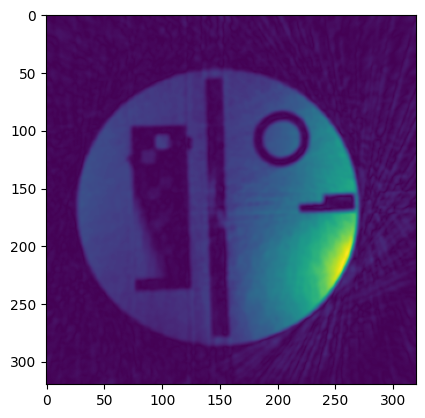

In [26]:
plt.imshow(img[140].abs())

In [23]:
data_dict["cse"][0, 0].shape

torch.Size([30, 225, 320, 320])

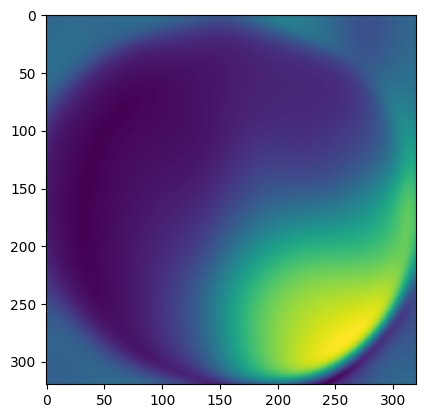

In [26]:
from matplotlib import pyplot as plt

plt.imshow(data_dict["cse"][0, 0][8, 128].abs())